# CTG Basic Denoise

see: https://physionet.org/physiobank/database/ctu-uhb-ctgdb/
and 'A Comprehensive Feature Analysis of the Fetal Heart Rate Signal for the Intelligent Assessment of Fetal State'

### Signal Preprocessing


In clinical practice, during the recording process using Doppler ultrasound, the FHR signal
contains many artifacts or spikes due to maternal and fetal movements or transducer displacement [1].  Therefore, before further analysis, we eliminated noise to obtain a relatively pure signal for more accurate results, as described in Reference [18].

In this work, we employed a preprocessing involving three steps.  Assume x(i) is an FHR signal with unit of beats per min (bpm) and a frequency of 4 Hz, where i = 1,2, ..., N and N is the number of samples.

- A stable segment is chosen as the starting point; in such a segment, five adjacent samples do not differ by more than 10 bpm, and missing data are excluded when the length of x(i) = 0 is equal or more than 10 s.

- Values of x(i) ≤50 or x(i) ≥ 200  are considered data spikes and are removed using linear interpolation

- We extrapolate x(i) using spline interolation again when the difference between x(i) and x(i-1) exceed 25 bpm, a value used to define unstable segments


Twenty minutes (N = 4800 samples) of signal length was the target used for further continuous
processing in this paper. Taking the signal labeled No. 1001 as a typical example, the result of this artifact removal scheme is presented in Figure 3.

In [1]:
import config_local
from config_common import *

In [2]:
import wfdb
import os
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
from scipy import interpolate

import pywt

In [3]:
from ctg_utils import get_all_recno, parse_meta_comments
from swt_filter import swt_align, replace_invalid_values, swt_process_signal, swt_process_uc_signal

# Code

In [4]:
local_recordings_dir_full

'/Users/Test/Documents/GitHub/CTG_Analysis/local_data/sample_physionet_ctb_uhb_recordings'

In [5]:
!ls /Users/Test/Documents/GitHub/CTG_Analysis/local_data/sample_physionet_ctb_uhb_recordings

1001.dat 1001.hea 1002.dat 1002.hea


In [6]:
def find_valid_start(sig, n_stable=5, min_delta=10):
    for i in range(len(sig)-n_stable ):
        max_value = np.max(sig[i:i+n_stable])
        min_value = np.min(sig[i:i+n_stable])
        
        if max_value == 0: continue 
        if max_value - min_value > min_delta: continue
        return i
    
    return None

In [7]:
def remove_extreme_values(sig_hr, min_hr=50, max_hr=200):
    mask = np.logical_and(sig_hr > min_hr, sig_hr < max_hr)
    n_valid = np.sum(mask)

    if n_valid != len(mask) and n_valid > 0:
        # print('found masked values', len(mask) - n_valid)
        x = np.arange(len(mask))
        new_sig = np.interp(x, x[mask], sig_hr[mask])
        
    return new_sig, mask

In [8]:
def find_gaps(sig):
    missing = sig == 0
    i_start = 0
    gaps = []
    while i_start < len(missing):
        i_start = np.argmax(missing[i_start:]) + i_start  # start of gap
        if not missing[i_start]: 
            break
            
        i_end = np.argmin(missing[i_start:]) + i_start   # end of gap
        if i_end == i_start:
            i_end = len(missing)   # reached end

        n_gap = i_end - i_start
        gaps.append([n_gap, i_start, i_end])
        i_start = i_end

    return gaps

In [9]:
def trim_short_segments(sig, verbose=False, min_seg=12):
    gaps = find_gaps(sig)
    for i in range(1, len(gaps)):
        n_seg = gaps[i][1] - gaps[i-1][2]
        if n_seg <= min_seg and n_seg < min(gaps[i-1][0], gaps[i][0]):
            found = True
            sig[gaps[i-1][2]:gaps[i][1]] = 0
            if verbose:
                print('n_seg', n_seg,  gaps[i-1][0], gaps[i][0])
    return sig

In [10]:
def find_valid_segments(sig, min_segment_width=8*60*4, 
                        max_allowed_gap=10*4, verbose=False):
    
    gaps = find_gaps(sig)
    gaps = [g for g in gaps if g[0] > max_allowed_gap]
    if verbose:
        for g in gaps:
            print('gap @ {:0.2f} min for {:0.2f} sec  index: {} '.format(
                g[1]/4/60, g[0]/4, g[1:]))

    n_sig = len(sig)
    valid_segments = []
    seg_start = 0
    
    for _, gap_start, gap_end in gaps:
        seg_end = gap_start               # gap ends valid segment
        n_seg = seg_end - seg_start
        if n_seg >= min_segment_width:    # ignore short segments
            valid_segments.append([seg_start, seg_end])
        seg_start = gap_end
        
    if seg_start < n_sig:     # special case for final segment
        seg_end = n_sig
        n_seg = seg_end - seg_start
        if n_seg >= min_segment_width:
            valid_segments.append([seg_start, seg_end])
            
    if verbose:
        print('valid_segments')
        pprint(valid_segments)
    return valid_segments

In [11]:
def filter_extreme_values(seg_hr, min_hr=50, max_hr=200):
    seg_hr[seg_hr < min_hr] = 0
    seg_hr[seg_hr > max_hr] = 0
    
    return seg_hr

In [12]:
def replace_missing_values(sig):
    valid = sig > 0
    n_valid = np.sum(valid)
    n_missing = len(valid) - n_valid

    if n_missing > 0 and n_valid > 0:
        x = np.arange(len(valid))
        new_sig = np.interp(x, x[valid], sig[valid])
        
    return new_sig, valid

In [13]:
def filter_large_changes(sig, valid, tm, max_change=25, w=8, verbose=False):
    change_mask = np.abs(sig[4:] - sig[:-4]) > max_change
    change_mask = np.logical_and(change_mask, np.logical_and(valid[4:], valid[:-4]))
    if np.sum(change_mask) == 0:
        return sig, valid
    
    change_mask = np.pad(change_mask, (4,0), 'edge')
    
    if verbose:
        plt.figure(figsize=(12, 2))
        plt.title('filter_large_changes: Invalid')
        plt.plot(change_mask)
        plt.xlim(0,)
        plt.ylim(-0.1,1.1)
        plt.show()
    
        plt.figure(figsize=(12, 2))
        plt.title('filter_large_changes')
        plt.plot(tm, sig)
        for i, val in enumerate(change_mask):
            if val:
                plt.plot([tm[i],tm[i]], [50, 200], 'r', alpha=0.125)
                #plt.plot([tm[i+4],tm[i+4]], [50, 200], 'r', alpha=0.125)
        plt.ylim(50,200)
        plt.xlim(tm[0],)
        plt.show()
    
    x = np.arange(len(change_mask))
    sig = np.interp(x, x[~change_mask], sig[~change_mask])
    
    if verbose:
        plt.figure(figsize=(12, 2))
        plt.title('filter_large_changes: interpolated')
        plt.plot(tm, sig)
        plt.xlim(tm[0],)
        plt.ylim(50,200)
        plt.show()
        
    valid[change_mask] = False

    return sig, valid

## Process Recordings


Record: 1001
nSamples: 19200

****************************************

Segment 0-5254


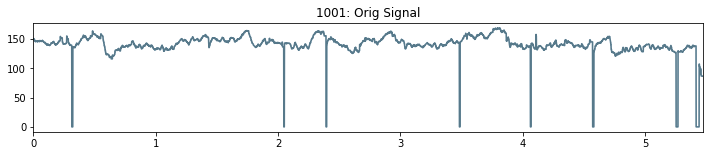

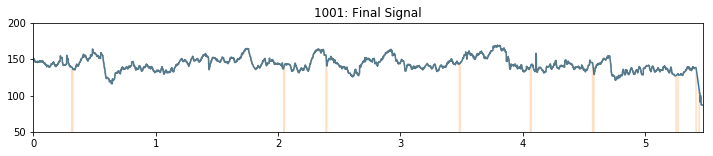

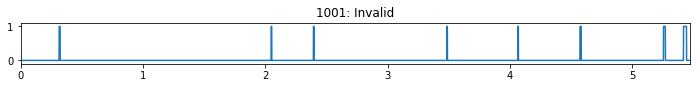

Valid: 98.5%

Record: 1002
nSamples: 19200

****************************************

Segment 0-9601


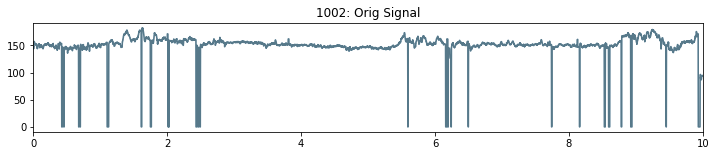

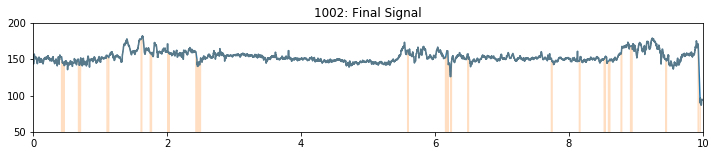

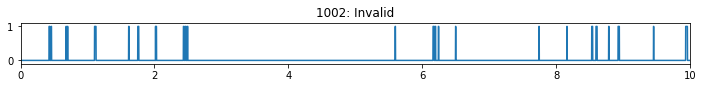

Valid: 97.5%

****************************************

Segment 11298-14418


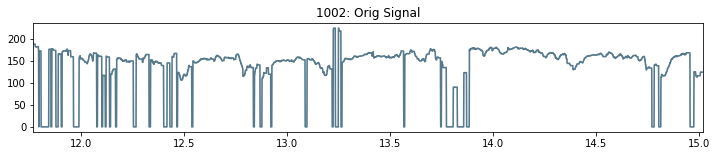

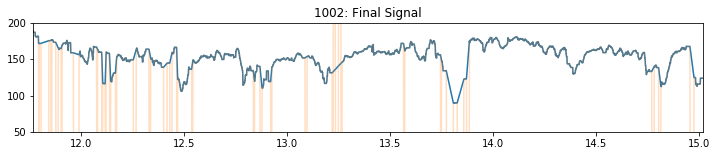

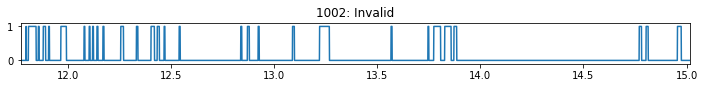

Valid: 88.6%


In [14]:
for recno in sorted(get_all_recno(local_recordings_dir_full)):
    recno_full = os.path.join(local_recordings_dir_full, recno)
    print('\nRecord: {}'.format(recno))
    all_sig, meta = wfdb.io.rdsamp(recno_full)
    print('nSamples: {}'.format(all_sig.shape[0]))
    #pprint(meta['comments'])
    
    orig_hr = all_sig[:, 0]
    sig_hr = np.copy(orig_hr)
    sig_uc = all_sig[:, 1]
    ts = np.arange(len(sig_hr))/4.0
    
    i_start = find_valid_start(sig_hr)
    # print(i_start)
    assert i_start is not None

    orig_hr = orig_hr[i_start:]
    sig_hr = sig_hr[i_start:]
    sig_uc = sig_uc[i_start:]
    ts = ts[i_start:]
    tm = ts / (4*60)
    
    sig_hr = trim_short_segments(sig_hr)
    valid_segments = find_valid_segments(sig_hr)
    # pprint(valid_segments)
    
    for seg_start, seg_end in valid_segments:
        print()
        print('*'*40)
        print()
        print('Segment {}-{}'.format(seg_start, seg_end))
        seg_hr = sig_hr[seg_start:seg_end]
        seg_ts = ts[seg_start:seg_end]
        seg_tm = tm[seg_start:seg_end]
        
    
        #sig_hr, mask = remove_extreme_values(sig_hr)

        plt.figure(figsize=(12, 2))
        plt.title('{}: Orig Signal'.format(recno))
        plt.plot(seg_tm, seg_hr)
        plt.plot(seg_tm, orig_hr[seg_start:seg_end], alpha=0.25)
        plt.xlim(seg_tm[0],seg_tm[-1])
        plt.show()
        
        
        seg_hr = filter_extreme_values(seg_hr)

        if False:
            plt.figure(figsize=(12, 2))
            plt.title('{}: Signal Filtered'.format(recno))
            plt.plot(seg_tm, seg_hr)
            plt.plot(seg_tm, orig_hr[seg_start:seg_end], alpha=0.25)
            plt.xlim(seg_tm[0],seg_tm[-1])
            plt.show()
        
        
        # adjust for stability at start of recording)
        new_start = find_valid_start(seg_hr)
        if new_start is None:
            print('unable to find stable region')
            continue
        elif new_start != seg_start:
            seg_start = seg_start + new_start
            seg_hr = sig_hr[seg_start:seg_end]
            seg_ts = ts[seg_start:seg_end]
            seg_tm = tm[seg_start:seg_end]
            
        new_seg_hr, mask = replace_missing_values(seg_hr)
        
        if False:
            plt.figure(figsize=(12, 2))
            plt.title('{}: Signal Interpolated'.format(recno))
            plt.plot(seg_tm, new_seg_hr)
            plt.plot(seg_tm, orig_hr[seg_start:seg_end], alpha=0.25)
            plt.xlim(seg_tm[0],seg_tm[-1])
            plt.show()

            plt.figure(figsize=(12, 2))
            plt.title('{}: Valid'.format(recno))
            plt.plot(seg_tm, mask)
            plt.xlim(seg_tm[0],seg_tm[-1])
            plt.ylim(-0.1,1.1)
            plt.show()
        
        new_seg_hr, mask = filter_large_changes(new_seg_hr, mask, seg_tm, max_change=25)
        
        plt.figure(figsize=(12, 2))
        plt.title('{}: Final Signal'.format(recno))
        plt.plot(seg_tm, new_seg_hr)
        plt.plot(seg_tm, orig_hr[seg_start:seg_end], alpha=0.25)
        plt.xlim(seg_tm[0],seg_tm[-1])
        plt.ylim(50,200)
        plt.show()
        
        plt.figure(figsize=(12, 0.75))
        plt.title('{}: Invalid'.format(recno))
        plt.plot(seg_tm, ~mask)
        plt.xlim(seg_tm[0],seg_tm[-1])
        plt.ylim(-0.1,1.1)
        plt.show()
        
        print('Valid: {:0.1f}%'.format(100*np.mean(mask)))
    